In [5]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users)

In [1]:
from helpers_lab import load_data, preprocess_data

#path_dataset = "movielens100k.csv"
train_dataset = "./datas/data_train.csv"
test_dataset = "./datas/sampleSubmission.csv"
ratings = load_data(train_dataset)
test_file = load_data(test_dataset)

number of items: 10000, number of users: 1000
number of items: 10000, number of users: 1000


In [197]:
ratings.shape

(1682, 943)

### Plot the number of ratings per movie and user

In [2]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

<Figure size 1000x500 with 2 Axes>

min # of items per user = 8, min # of users per item = 3.


### Split the data into a train and test set

In [3]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0] # tuple ([0],)
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][: , valid_users]  
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # split the data and return train and test data. TODO
    # NOTE: we only consider users and movies that have more
    # than 10 ratings
    # ***************************************************
    
    # init
    num_rows, num_cols = valid_ratings.shape
    # Row-based linked list sparse matrix
    train = sp.lil_matrix((num_rows, num_cols))
    test = sp.lil_matrix((num_rows, num_cols))
    
    print("the shape of original ratings. (# of row, # of col): {}".format(
        ratings.shape))
    print("the shape of valid ratings. (# of row, # of col): {}".format(
        (num_rows, num_cols)))
    
    nz_items, nz_users = valid_ratings.nonzero()
    
    # Split data
    for user in set(nz_users):
        # randomly select a subset of ratings
        row, col = valid_ratings[:, user].nonzero()
        selects = np.random.choice(row, size=int(len(row) * p_test))
        residual = list(set(row) - set(selects))

        # add to train set
        train[residual, user] = valid_ratings[residual, user]

        # add to test set
        test[selects, user] = valid_ratings[selects, user]
    
    print("Total number of nonzero elements in origial data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test

the shape of original ratings. (# of row, # of col): (10000, 1000)
the shape of valid ratings. (# of row, # of col): (9990, 999)
Total number of nonzero elements in origial data:1176952
Total number of nonzero elements in train data:1065253
Total number of nonzero elements in test data:111620


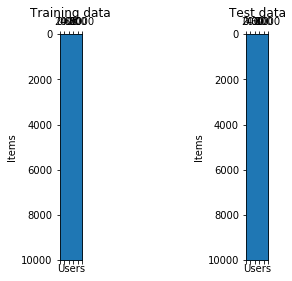

In [6]:
from plots import plot_train_test_data

valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)
plot_train_test_data(train, test)

## Implementing Baselines 

### Use the global mean to do the prediction

In [8]:
from helpers_lab import calculate_mse

def baseline_global_mean(train, test):
    """baseline method: use the global mean."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # ***************************************************    
    # find the non zero ratings in the train
    nonzero_train = train[train.nonzero()]
    global_mean_train = nonzero_train.mean()
    
    # find the non zero ratings in test
    nonzero_test = test[test.nonzero()].toarray()
    
    # predict the ratings as global mean
    mse = calculate_mse(nonzero_test, global_mean_train)
    rmse = np.sqrt(1.0 * mse / nonzero_test.shape[1])
    print("test RMSE of baseline using the global mean: {v}.".format(v=rmse))

    return nonzero_test, global_mean_train

a, b = baseline_global_mean(train, test)

test RMSE of baseline using the global mean: [[1.12152228]].


In [9]:
print(b) # global_mean is one number

3.8581107023810133


### Use the user means as the prediction

In [10]:
def baseline_user_mean(train, test):
    """baseline method: use the user means as the prediction."""
    mse = 0
    num_items, num_users = train.shape
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # ***************************************************
    for user_index in range(num_users):
        # find the non-zero ratings for each user in the training dataset
        train_ratings = train[:, user_index]
        nonzeros_train_ratings = train_ratings[train_ratings.nonzero()]
        
        # calculate the mean if the number of elements is not 0
        if nonzeros_train_ratings.shape[0] != 0:
            user_train_mean = nonzeros_train_ratings.mean()
        else:
            continue
        
        # find the non-zero ratings for each user in the test dataset
        test_ratings = test[:, user_index]
        nonzeros_test_ratings = test_ratings[test_ratings.nonzero()].todense()
        
        # calculate the test error 
        mse += calculate_mse(nonzeros_test_ratings, user_train_mean)
        
    rmse = np.sqrt(1.0 * mse / test.nnz)
    print("test RMSE of the baseline using the user mean: {v}.".format(v=rmse))

baseline_user_mean(train, test)

test RMSE of the baseline using the user mean: [[1.03317038]].


### Use the item means as the prediction

In [11]:
def baseline_item_mean(train, test):
    """baseline method: use item means as the prediction."""
    mse = 0
    num_items, num_users = train.shape
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # ***************************************************
    for item_index in range(num_items):
        train_ratings = train[item_index, :]
        nonzeros_train_ratings = train_ratings[train_ratings.nonzero()]
        
        # calculate the mean if the number of elements is not 0
        if nonzeros_train_ratings.shape[0] != 0:
            item_train_mean = nonzeros_train_ratings.mean()
        else:
            continue
            
        # find the non-zero ratings for each user in the test dataset
        test_ratings = test[item_index, :]
        nonzeros_test_ratings = test_ratings[test_ratings.nonzero()].todense()
        
        # calculate the test error 
        mse += calculate_mse(nonzeros_test_ratings, item_train_mean)
        
    rmse = np.sqrt(1.0 * mse / test.nnz)
    print("test RMSE of the baseline using the item mean: {v}.".format(v=rmse))
    
baseline_item_mean(train, test)

test RMSE of the baseline using the item mean: [[1.09633198]].


### Learn the Matrix Factorization using SGD

#### Initialize matrix factorization

In [12]:
def init_MF(train, num_features):
    # num_features = k
    """init the parameter for matrix factorization.
       Split X = W @ K """
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # you should return:
    #     user_features: shape = num_features, num_user
    #     item_features: shape = num_features, num_item
    # ***************************************************
    num_item, num_user = train.get_shape()
    
    # random init
    user_features = np.random.rand(num_features, num_user) # k x n --> user.T => n x k 
    item_features = np.random.rand(num_features, num_item) # k x d
    
    # start by item features.
    item_nnz = train.getnnz(axis=1) # Get the count of explicitly-stored values (nonzeros) - 1152
    item_sum = train.sum(axis=1) # array of sum per item 1 (i.e. sum[0] = sum over all ratings of 943 reviewers for item 0)
    
    for ind in range(num_item):
        item_features[0, ind] = item_sum[ind, 0] / item_nnz[ind] # W
    
    return user_features, item_features # W, Z

num_features = 20   # K in the lecture notes
lambda_user = 0.1
lambda_item = 0.7
num_epochs = 20     # number of full passes through the train set
errors = [0]

# set seed
np.random.seed(988)

# init matrix
user, item = init_MF(train, num_features)

print(user.shape, item.shape) # W = 1152 * 20 Z = 20 * 943

(20, 999) (20, 9990)


Compute the cost by the method of matrix factorization.


In [13]:
def compute_error(data, user_features, item_features, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # calculate rmse (we only consider nonzero entries.)
    # ***************************************************
    mse = 0
    for row, col in nz:
        user_feature = user_features[:, col]
        item_feature = item_features[:, row]
        pred = user_feature.T.dot(item_feature) # same as item_feature.T (1152 x 20) * user_feature (20 x 934)
        ground_truth = data[row, col]
        mse += (ground_truth - pred)**2
    return np.sqrt(1.0 * mse / len(nz))

In [14]:
nz_row, nz_col = train.nonzero()
nz_train = list(zip(nz_row, nz_col)) # (item, user) of non-zero ratings
compute_error(train, user_features, item_features, nz_train)

NameError: name 'user_features' is not defined

In [15]:
def matrix_factorization_SGD(train, test):
    """matrix factorization by SGD."""
    # define parameters
    gamma = 0.01
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    num_epochs = 20     # number of full passes through the train set
    errors = [0]
    
    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))

    print("learn the matrix factorization using SGD...")
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= 1.2
        
        for d, n in nz_train:
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO
        # do matrix factorization.
        # ***************************************************
            # update W_d (item_features[:, d]) and Z_n (user_features[:, n])
            item_info = item_features[:, d]
            user_info = user_features[:, n]
            err = train[d, n] - user_info.T.dot(item_info) # loss function

    #         calculate the gradient and update
            item_features[:, d] += gamma * (err * user_info - lambda_item * item_info)
            user_features[:, n] += gamma * (err * item_info - lambda_user * user_info)

        # WRONG! 
    #         item_features[:, d] =  item_features[:, d] - gamma * err * item_features[d, n]
    #         user_features[:, n] =  user_features[:, n] - gamma * err * user_features[d, n]

        rmse = compute_error(train, user_features, item_features, nz_train)
        print("iter: {}, RMSE on training set: {}.".format(it, rmse))

        errors.append(rmse)
    # ***************************************************
    # TODO
    # evaluate the test error.
    # ***************************************************
    rmse = compute_error(test, user_features, item_features, nz_test)
    print("RMSE on test data: {}.".format(rmse))
    

matrix_factorization_SGD(train, test)   

learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 1.1188016390962718.
iter: 1, RMSE on training set: 1.0557733846363557.
iter: 2, RMSE on training set: 1.0352090447321285.
iter: 3, RMSE on training set: 1.0305003556868906.
iter: 4, RMSE on training set: 1.0289338540768067.
iter: 5, RMSE on training set: 1.027541155288929.
iter: 6, RMSE on training set: 1.0267280525334728.
iter: 7, RMSE on training set: 1.0257331157481897.
iter: 8, RMSE on training set: 1.024212863517716.
iter: 9, RMSE on training set: 1.0250155714728297.
iter: 10, RMSE on training set: 1.0250110976515387.
iter: 11, RMSE on training set: 1.0247649821945568.
iter: 12, RMSE on training set: 1.024444922433812.
iter: 13, RMSE on training set: 1.0243942405531554.
iter: 14, RMSE on training set: 1.0244300096163954.
iter: 15, RMSE on training set: 1.0244421403898756.
iter: 16, RMSE on training set: 1.0243492826217602.
iter: 17, RMSE on training set: 1.0241854571274716.
iter: 18, RMSE on training set: 1

### Learn the Matrix Factorization using Alternating Least Squares

In [16]:
def update_user_feature(
        train, item_features, lambda_user,
        nnz_items_per_user, nz_user_itemindices):
    """update user feature matrix."""
    """the best lambda is assumed to be nnz_items_per_user[user] * lambda_user"""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # update and return user feature.
    # ***************************************************
    num_user = nnz_items_per_user.shape[0] # (943 users, 1 item)
    num_feature = item_features.shape[0] # item_features = k * 1152 (D)
    
    lambda_I = lambda_user * sp.eye(num_feature) #sp.eye => Identity matrix - lambda * I_k
    updated_user_features = np.zeros((num_feature, num_user))
    
    for user, items in nz_user_itemindices: # indices of all the items rated by user g
        # extract the columns corresponding to the prediction for given item
        M = item_features[:, items] # shape :  (20 (k), nb of items rated by user g)
        # update column row of user features
        V = M @ train[items, user] # train[items, user] shape: (nb of items rated by user g, 1) - W.T @ X_n
        A = M @ M.T + nnz_items_per_user[user] * lambda_I # W.T @ W + Z (nnz_items_per_user - (943, 1)) * lambda * I_k
        X = np.linalg.solve(A, V)
        updated_user_features[:, user] = np.copy(X.T) # for one user, go through all items
    return updated_user_features
    

def update_item_feature(
        train, user_features, lambda_item,
        nnz_users_per_item, nz_item_userindices):
    """update item feature matrix."""
    """the best lambda is assumed to be nnz_items_per_item[item] * lambda_item"""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # update and return item feature.
    # ***************************************************
    num_item = nnz_users_per_item.shape[0] # (1152 (items), for 1 user)
    num_feature = user_features.shape[0]
    
    lambda_I = lambda_item * sp.eye(num_feature)
    updated_item_features = np.zeros((num_feature, num_item)) # inversed from the derive per user above
    
    for item, users in nz_item_userindices: # indices of all the users who rated item g
        # extract the rows corresponding to the prediction of given user
        M = user_features[:, users] # shape: (k (20), nb of users)
        # update row column of item features
        V = M @ train[item, users].T 
        A = M @ M.T + nnz_users_per_item[item] * lambda_I
        X = np.linalg.solve(A, V)
        updated_item_features[:, item] = np.copy(X.T) # ????? for one item, go through all users
    return updated_item_features

In [17]:
from helpers import build_index_groups


def ALS(train, test):
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    stop_criterion = 1e-4
    change = 1
    error_list = [0, 0]
    
    # set seed
    np.random.seed(988)

    # init ALS
    user_features, item_features = init_MF(train, num_features)
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # start you ALS-WR algorithm.
    # ***************************************************
    # get the number of non-zero ratings for each user and item
    nnz_items_per_user, nnz_users_per_item = train.getnnz(axis=0), train.getnnz(axis=1)
    
#     print(nnz_items_per_user)
    
    # group the indices by row or column index
    nz_train, nz_item_userindices, nz_user_itemindices = build_index_groups(train)

    # run ALS
    print("\nstart the ALS algorithm...")
    while change > stop_criterion: # continue until no changes
        # update user feature & item feature
        user_features = update_user_feature(
            train, item_features, lambda_user,
            nnz_items_per_user, nz_user_itemindices)
        item_features = update_item_feature(
            train, user_features, lambda_item,
            nnz_users_per_item, nz_item_userindices)

        error = compute_error(train, user_features, item_features, nz_train)
        print("RMSE on training set: {}.".format(error))
        error_list.append(error)
        change = np.fabs(error_list[-1] - error_list[-2]) 
        # Compute the absolute values element-wise. - Last with the previous last i.e. this error vs last error

    # evaluate the test error
    nnz_row, nnz_col = test.nonzero()
    nnz_test = list(zip(nnz_row, nnz_col))
    rmse = compute_error(test, user_features, item_features, nnz_test)
    print("test RMSE after running ALS: {v}.".format(v=rmse))


ALS(train, test)

ImportError: cannot import name 'build_index_groups'

In [ ]:
user_features, item_features = init_MF(train, num_features)
print(item_features.shape)